# High Frequency Option Trading

Leo Luo

Strategy part is starting from half of the document.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import Quandl
import functools
import seaborn as sns
import ggplot as gg
import collections
import datetime 
#from datetime import datetime
import gzip

## Read Risk Free Rate and Implied Vol Data From Quandl

In [3]:
#save data to cache
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities):
    qdata = Quandl.get(list(my_securities), trim_start='2014-09-28', trim_end='2014-10-31', collapse="daily", 
                       returns="pandas", authtoken="TzTcmaHpPQtRD3s_g2Z3")
    return qdata

#clean and make data look nicer
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('.')
        replacement_columns[c] = asset+":"+variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

In [4]:
#read data from Quandl
data_list = ('OWF/CME_ES_ES_Z2014_IVM','FED/RILSPDEPM01_N_B')
#data_list = ('CME/ESZ2014','FED/RILSPDEPM01_N_B')
raw_data = fetch_quandl(data_list)
raw_data = clean_quandl_columns(raw_data)


In [5]:
cdata = raw_data[['CME_ES_ES_Z2014_IVM:AtM','RILSPDEPM01_N_B:Value']].copy()
cdata.columns=['Vol','Rf']
cdata.head()

,Vol,Rf
Date,,
2014-09-29,0.137628,0.17
2014-09-30,0.141173,0.17
2014-10-01,0.150086,0.17
2014-10-02,0.147139,0.17
2014-10-03,0.135447,0.17


## Read High Frequency Data

In [6]:
useful_info_fields = {
    '107': 'SecurityDesc',
    '268': 'NoMDEntries', # number of entries
    '269': 'MDEntryType', # 0=Bid, 1=Offer, 2=Trade
    '270': 'MDEntryPx', # Price
    '279': 'MDUpdateAction', 
    '35': 'MsgType',
    '48': 'SecurityID',
    '52': 'SendingTime',
    '75': 'TradeDate',
    # The following are trickier to parse due to repeating according to entry types
    #'1020': 'TradeVolume',
    #'1023': 'MDPriceLevel',
    #'271': 'MDEntrySize', 
    #'277': 'TradeCondition', 
}

In [7]:
def check_equal(iterator):
    try:
        iterator = iter(iterator)
        first = next(iterator)
        return all(first == rest for rest in iterator)
    except StopIteration:
        return True
def fields_in(line):
    """
    Parse a FIX message line into a list of dicts, each 
     one representing a market data update
    """
    f = {}
    group_count = None
    observed_group_count = 1
    field_values = [f.split("=") for f in line.split("\x01") if f]
    # Unused, but parse the official mkt update count
    for field,field_value in field_values:
        if field=='268':
            group_count = int(field_value)
    # Record field values
    for field,field_value in field_values:
        if field in useful_info_fields:
            info_field = useful_info_fields[field]
            if info_field in f:
                if isinstance(f[info_field],list):
                    # This field has already been given to us more than once.  Append to the list.
                    f[info_field].append(field_value)
                else:
                    # We have seen this field before and now are seeing it a second time.  Turn it into
                    #  a list
                    existing = f[info_field]
                    f[info_field] = [existing, field_value]
            else:
                # We never saw this field before.  Record its value.
                f[info_field] = field_value
    # Find out how many market updates this message contained
    for field,field_value in f.items():
        if isinstance(field_value,list):
            if check_equal(field_value):
                # Don't bother with cases where all updates had the same value
                f[field] = field_value[0]
            else:
                # Differing values in updates.  Count them.
                num_this_group = len(field_value)
                # Safety check
                if observed_group_count>1 and num_this_group!=observed_group_count:
                    print("Surprise got %d not %d from %s=%s\n%s\n%s\n-------------------------"%(
                            num_this_group,observed_group_count,field,field_value,
                            ' | '.join(line.split("\x01")),
                            ' | '.join(sorted(line.split("\x01"))),
                        ))
                else:
                    observed_group_count = max(observed_group_count,num_this_group)
    # Safety checks
    for field,field_value in f.items():
        if isinstance(field_value,list) and len(field_value)!=observed_group_count:
            print("Error: saw %d values for %s but observed_group_count was %s\n%s"%(
                len(field_value),field,observed_group_count,sorted(field_values) ))
    # Create list of market updates from message field lists
    if group_count and group_count>1:
        gf = [f.copy() for i in range(group_count)]
        for field,field_value in f.items():
            if isinstance(field_value,list):
                for j in range(group_count):
                    gf[j][field] = field_value[j]
    else:
        gf = [f]
    return gf
#fields_in(sample_line)

In [8]:
def parse_timestamp(s):
    dt_args = [int(x) for x in (s[:4],s[4:6],s[6:8],s[8:10],s[10:12],s[12:14],s[14:])]
    dt_args[-1] *= 1000
    return datetime.datetime(*tuple(dt_args))

In [9]:
def get_dense(desc,subsample_file):
    dense_trade_prices_list = []
    N = 0
    with gzip.open(subsample_file,"rt") as ssfile:
        for line in ssfile:
            fields_list = fields_in(line.strip())
            for fields in fields_list:
                if desc==fields.get('SecurityDesc') and '2'==fields.get('MDEntryType'):
                    price_observed = 0.01*float(fields['MDEntryPx'])
                    t = parse_timestamp(fields['SendingTime'])
                    dense_trade_prices_list.append((t,price_observed))
                    N += 1
    print("Found %d"%N)
    return dense_trade_prices_list

In [10]:
def get_dense_frame(desc,subsample_file):
    dense_list = get_dense(desc,subsample_file)
    dense_frame = pd.DataFrame(dense_list,
                                    columns=("Timestamp","Trade"))
    dense_frame.set_index(["Timestamp"], inplace=True)
    dense_prices = dense_frame["Trade"]
    return dense_prices

### Read Futures Data
### Reading Step is only done once, then we have the saved 'pkl' file to load.


In [11]:
#big_subsample_file = "s0929_1031.gz"
#dense_trade_prices = get_dense_frame(desc='ESZ4',
#                                     subsample_file=big_subsample_file)
#dense_trade_prices.to_pickle('dense_trade_prices.pkl')

In [12]:
dense_trade_prices = pd.read_pickle('dense_trade_prices.pkl')
dense_trade_prices = pd.DataFrame(dense_trade_prices)
dense_trade_prices = dense_trade_prices.reset_index().drop_duplicates(subset='Timestamp',keep='last').set_index('Timestamp')
dense_trade_prices = dense_trade_prices.sort_index()
#dense_trade_prices.head()

In [13]:
dense_trade_prices.describe()

,Trade
count,2.973868e+06
mean,1.940147e+03
std,3.284354e+01
min,1.863750e+03
25%,1.921500e+03
50%,1.943750e+03
75%,1.964000e+03
max,2.016750e+03


In [14]:
#print(dense_trade_prices.index[0])
#print(dense_trade_prices.index[-1])
#dense_trade_prices.plot(title="Dec Contract Prices")
#see the price with step
#dense_trade_prices.iloc[0:2600000:1000].plot(title="Dec Contract Prices")
#lab = plt.ylabel("$")

We see more market microstructure when we zoom in

In [15]:
#dense_trade_prices.iloc[-1000000:-600:1000].plot(title="Dec Contract Prices")
#lab = plt.ylabel("$")


In [7]:
#USE HDF to save data
store = pd.HDFStore('store.h5')
store['dense_trade_prices'] = dense_trade_prices
dense_trade_prices_base = store['dense_trade_prices']
#dense_trade_prices_base.head()

In [ ]:
store = pd.HDFStore('store.h5')
len(store['dense_trade_prices'])

In [6]:
store.close()

Option: 1865 Put

In [16]:
#load option file
option_subsample_file = "P1865_s0929_1031.gz"
dense_opt_prices = get_dense_frame(desc='ESX4 P1865',
                                     subsample_file=option_subsample_file)
dense_opt_prices = pd.DataFrame(dense_opt_prices )
dense_opt_prices = dense_opt_prices.reset_index().drop_duplicates(subset='Timestamp', keep='last').set_index('Timestamp')
dense_opt_prices = dense_opt_prices.sort_index()
dense_opt_prices.columns =['Oprice']
dense_opt_prices.index = dense_opt_prices.index.rename('Time')
dense_opt_prices['date'] =dense_opt_prices.index.map(lambda x: datetime.datetime(int(x.year),int(x.month),int(x.day)))
#dense_opt_prices.head()

Found 259


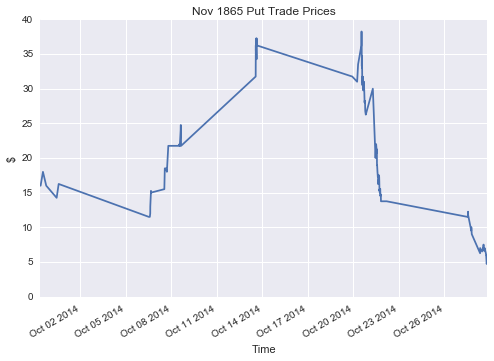

In [17]:
# look at the data
dense_opt_prices['Oprice'].plot(title="Nov 1865 Put Trade Prices", 
                      #style="o", 
                      markerfacecolor='none', markeredgecolor='green',
                     markersize=15)
lab = plt.ylabel("$")
#dense_opt_prices.plot()

In [18]:
dense_opt_prices.groupby('date').agg('count').sort_values('Oprice',ascending=False).head()

,Oprice
date,
2014-10-21,57
2014-10-20,54
2014-10-08,30
2014-10-28,25
2014-10-27,15


## Greeks Formula

In [19]:
#Black Scholes
import numpy as np
import scipy.stats as ss
from scipy.stats import norm
#import time 

#Black and Scholes
def d1(S0, K, r, sigma, T):
    return (np.log(S0/K) + (r + sigma**2 / 2) * T)/(sigma * np.sqrt(T))
 
def d2(S0, K, r, sigma, T):
    return (np.log(S0 / K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
 
def BlackScholes(type,S0, K, r, sigma, T):
    if type=="C":
        return S0 * ss.norm.cdf(d1(S0, K, r, sigma, T)) - K * np.exp(-r * T) * ss.norm.cdf(d2(S0, K, r, sigma, T))
    else:
        return K * np.exp(-r * T) * ss.norm.cdf(-d2(S0, K, r, sigma, T)) - S0 * ss.norm.cdf(-d1(S0, K, r, sigma, T)) 

def delta(type,S0, K, r, sigma, T):
    if type=='C':
        return ss.norm.cdf(d1(S0, K, r, sigma, T))
    else:
        return ss.norm.cdf(d1(S0, K, r, sigma, T))-1

def Sbydelta(type, K, r, sigma, T, Pdelta):
    if type=='C':
        return np.exp(norm.ppf(Pdelta) * (sigma * np.sqrt(T)) - (r + sigma**2 / 2) * T + np.log(K))    
    else:
        return np.exp(norm.ppf(Pdelta+1) * (sigma * np.sqrt(T)) - (r + sigma**2 / 2) * T + np.log(K))

def gamma(S0, K, r, sigma, T):
    return norm.pdf( d1(S0, K, r, sigma, T)) / (S0 * sigma * np.sqrt(T))

## HEDGING STRATEGIES

1. Hedge when the future has moved so much that the absolute value of position delta exceeds a threshold D 
2. Hedge every M minutes (where M is typically between 30 and 240) 
3. Hedge every T futures trades (uncommon in quantitative specifications) 
4. A combination of the above

In [20]:
#Odata
# Trade data: Tdata
# Option data: Odata
# delta(type,S0, K, r, sigma, T)
# Sbydelta(type, K, r, sigma, T, Pdelta)
# gamma(S0, K, r, sigma, T)

## Hedge 1: Hedge by absolute Threshold List D

In [21]:
def hedging1(D, Tdata, Odata,cdata, expirationday, tradeday, Strike, otype):
    ImV, Rf = cdata.ix[tradeday,'Vol'], cdata.ix[tradeday,'Rf']
    day1 = datetime.datetime.strptime(tradeday, "%Y-%m-%d")
    day2 = datetime.datetime.strptime(expirationday, "%Y-%m-%d")
    T = abs((day1 - day2).days)/252
    S_last = Tdata.iloc[0]['Fprice']
    Opos = 1    #this can be changed, starting option positions
    delta_last = delta(otype, S_last, Strike, Rf, ImV, T) * Opos
    Ocost = Odata.iloc[0]['Oprice'] * Opos
    gamma_last = gamma(S_last, Strike, Rf, ImV, T)
    TradeTimeList =[Tdata.index[0]]
    fuPosList =[-delta_last]
    fuTradeCount = 0
    fuCost = -delta_last * S_last
    #TradeTimeLast = TradeTimeList[-1]
    #nexttradetime = TradeTimeLast + datetime.timedelta(minutes =M)
    for idx, row in Tdata.iterrows(): 
        St = row['Fprice']
        delta_cur = (St-S_last)*gamma_last
        if(abs(delta_cur) > D ):
            fuCost -= delta_cur  * S_last * Opos  #watch out for the sign here
            TradeTimeList.append(idx)
            fuPosList.append(-delta_cur + fuPosList[-1])
            #delta_last = delta_new
            S_last = St
            #nexttradetime += datetime.timedelta(minutes =M)
    #close positions
    S_closing = Tdata.iloc[-1]['Fprice']
    O_closing = Odata.iloc[-1]['Oprice']
    pnl_no_hedging = (-Ocost + O_closing * Opos)/Ocost
    pnl_final = fuPosList[-1] * S_closing - fuCost - Ocost + O_closing * Opos
    #print(fuPosList[-1] * S_closing, fuCost, Ocost, O_closing * Opos )
    pnl_final = pnl_final / Ocost
    return pnl_final, TradeTimeList, fuPosList, pnl_no_hedging

## Hedge 2 Hedge every M minutes (M is between 30-240)

In [22]:
def hedging2(M, Tdata, Odata,cdata, expirationday, tradeday, Strike, otype):
    ImV, Rf = cdata.ix[tradeday,'Vol'], cdata.ix[tradeday,'Rf']
    day1 = datetime.datetime.strptime(tradeday, "%Y-%m-%d")
    day2 = datetime.datetime.strptime(expirationday, "%Y-%m-%d")
    T = abs((day1 - day2).days)/252
    S_last = Tdata.iloc[0]['Fprice']
    Opos = 1
    Ocost = Odata.iloc[0]['Oprice'] * Opos
    delta_last = delta(otype, S_last, Strike, Rf, ImV, T) * Opos
    gamma_last = gamma(S_last, Strike, Rf, ImV, T)
    TradeTimeList =[Tdata.index[0]]
    fuPosList =[-delta_last]
    fuTradeCount = 0
    fuCost = -delta_last * S_last
    TradeTimeLast = TradeTimeList[-1]
    nexttradetime = TradeTimeLast + datetime.timedelta(minutes =M)
    for idx, row in Tdata.iterrows(): 
        #fuTradeCount += 1
        if(idx>nexttradetime):
            #print(fuCost)
            St = row['Fprice']
            delta_cur = gamma_last * (St - S_last)
            fuCost -= delta_cur * Opos * S_last  #watch out for the sign here
            TradeTimeList.append(idx)
            fuPosList.append(-delta_cur +fuPosList[-1])
            #delta_last = delta_new
            S_last = St
            nexttradetime += datetime.timedelta(minutes =M)
    #close positions
    S_closing = Tdata.iloc[-1]['Fprice']
    O_closing = Odata.iloc[-1]['Oprice']
    pnl_no_hedging = (-Ocost + O_closing * Opos)/Ocost
    pnl_final = fuPosList[-1] * S_closing - fuCost - Ocost + O_closing * Opos
    #print(fuPosList[-1] * S_closing, fuCost, Ocost, O_closing * Opos )
    pnl_final = pnl_final / Ocost
    return pnl_final, TradeTimeList, fuPosList,pnl_no_hedging

## Hedge 3 Hedge every T trades

In [23]:
def hedging3(tradesT, Tdata, Odata,cdata, expirationday, tradeday, Strike, otype):
    ImV, Rf = cdata.ix[tradeday,'Vol'], cdata.ix[tradeday,'Rf']
    day1 = datetime.datetime.strptime(tradeday, "%Y-%m-%d")
    day2 = datetime.datetime.strptime(expirationday, "%Y-%m-%d")
    T = abs((day1 - day2).days)/252
    S_last = Tdata.iloc[0]['Fprice']
    Opos = 1
    delta_last = delta(otype, S_last, Strike, Rf, ImV, T) * Opos
    Ocost = Odata.iloc[0]['Oprice'] * Opos
    gamma_last = gamma(S_last, Strike, Rf, ImV, T)
    TradeTimeList =[Tdata.index[0]]
    fuPosList =[-delta_last]
    fuTradeCount = 0
    fuCost = -delta_last * S_last
    for idx, row in Tdata.iterrows(): 
        fuTradeCount += 1
        if(int(fuTradeCount) % tradesT == 0):
            #print(fuTradeCount)
            St = row['Fprice']
            delta_cur = gamma_last * (St - S_last)
            fuCost -= delta_cur * Opos * S_last  #watch out for the sign here
            TradeTimeList.append(idx)
            fuPosList.append(-delta_cur + fuPosList[-1])
            S_last = St
    #close positions
    S_closing = Tdata.iloc[-1]['Fprice']
    O_closing = Odata.iloc[-1]['Oprice']
    pnl_no_hedging = (-Ocost + O_closing * Opos)/Ocost
    pnl_final = fuPosList[-1] * S_closing - fuCost - Ocost + O_closing * Opos
    pnl_final = pnl_final / Ocost
    return pnl_final, TradeTimeList, fuPosList, pnl_no_hedging

## Hedge 4: Combine 1,2,3

In [24]:
def hedging4(D, M, tradesT, Tdata, Odata,cdata, expirationday, tradeday, Strike, otype):
    ImV, Rf = cdata.ix[tradeday,'Vol'], cdata.ix[tradeday,'Rf']
    day1 = datetime.datetime.strptime(tradeday, "%Y-%m-%d")
    day2 = datetime.datetime.strptime(expirationday, "%Y-%m-%d")
    T = abs((day1 - day2).days)/252
    S_last = Tdata.iloc[0]['Fprice']
    Opos = 1
    delta_last = delta(otype, S_last, Strike, Rf, ImV, T) * Opos
    Ocost = Odata.iloc[0]['Oprice'] * Opos
    gamma_last = gamma(S_last, Strike, Rf, ImV, T)
    TradeTimeList =[Tdata.index[0]]
    fuPosList =[-delta_last]
    fuTradeCount = 0
    fuCost = -delta_last * S_last
    TradeTimeLast = TradeTimeList[-1]
    nexttradetime = TradeTimeLast + datetime.timedelta(minutes =M)
    for idx, row in Tdata.iterrows(): 
        fuTradeCount += 1
        St = row['Fprice']
        delta_cur = gamma_last * (St - S_last)
        if(int(fuTradeCount) % tradesT == 0) or (abs(delta_cur) > D) or (idx>nexttradetime):
            #print(fuTradeCount)
            fuCost -= delta_cur * Opos * S_last  #watch out for the sign here
            TradeTimeList.append(idx)
            fuPosList.append(-delta_cur + fuPosList[-1])
            S_last = St
            nexttradetime = TradeTimeList[-1] + datetime.timedelta(minutes =M)
    #close positions
    S_closing = Tdata.iloc[-1]['Fprice']
    O_closing = Odata.iloc[-1]['Oprice']
    pnl_no_hedging = (-Ocost + O_closing * Opos)/Ocost
    pnl_final = fuPosList[-1] * S_closing - fuCost - Ocost + O_closing * Opos
    pnl_final = pnl_final / Ocost
    return pnl_final, TradeTimeList, fuPosList, pnl_no_hedging

## Analysis

The following Analysis parts include analysis on the date when futures price drop, and the date when futures price go up. For both senario, we will explore and analyze how different parameters affect different strategy PnL, and the how the combination affects the PnL.

## A. ANALYSIS ON THE DAY WHEN OPTIONS PRICE DROP

This part we will take one day's trading as an example to show how paramater changes in every strategy affect the PnL. We will take the most option traded day 2014-10-21 as an example.

In [46]:
# Parameters Setting
expirationday ='2014-12-16'
tradeday = '2014-10-21'
Odata = dense_opt_prices.ix[datetime.datetime(2014,int(tradeday[5:7]),int(tradeday[8:10]),8):
                            datetime.datetime(2014,int(tradeday[5:7]),int(tradeday[8:10]),15)]
ostart, oend, starttime, endtime = Odata.iloc[0]['Oprice'], Odata.iloc[-1]['Oprice'], Odata.index[0], Odata.index[-1]
Tdata = dense_trade_prices.ix[starttime: endtime]
Tdata = pd.DataFrame(Tdata)
Tdata.columns=['Fprice']
otype ='P'
Strike = 1865
#ostart, oend, starttime, endtime

Options Price plot on 2014-10-21

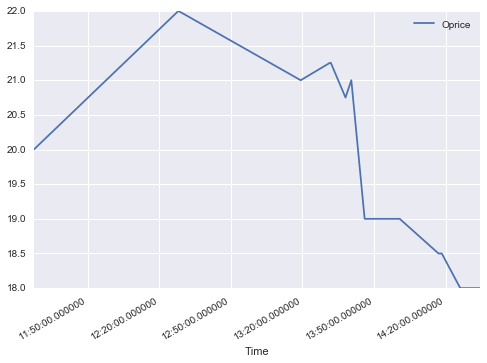

In [26]:
Odata.plot()

Futures Price plot on 2014-10-21

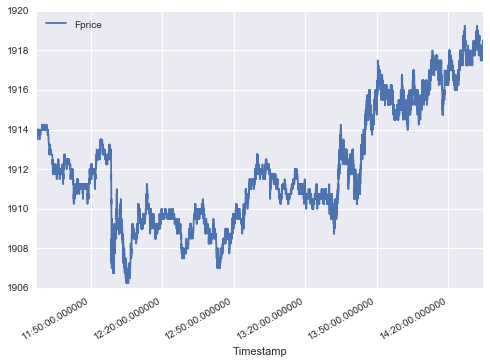

In [27]:
Tdata.plot()

Fuctions to get statistics and draw plot for strat 1,2,3

In [45]:
def getStat(strat,ParaList,*args):
    pnlList,pnl_nohedge_List, num_trades =[],[],[]
    for para in ParaList:
        pnl_final, _, fuPosList, pnl_no_hedging = strat(para, *args)
        pnlList.append(pnl_final)
        pnl_nohedge_List.append(pnl_no_hedging)
        num_trades.append(len(fuPosList))
    return pnlList,pnl_nohedge_List, num_trades

def drawStat(strat,ParaList,x1,y1,x2,y2='number of Trades',*args):
    pnlList,pnl_nohedge_List, num_trades = getStat(strat,ParaList,*args)
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.plot(ParaList, pnlList,label='pnl_hedged')
    #plt.plot(ParaList,pnl_nohedge_List,label='pnl_nohedge')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.xlabel(x1)
    plt.ylabel(y1)
    plt.subplot(122)
    plt.bar(ParaList,num_trades,width =(ParaList[1]-ParaList[0])/2,label ='number of trades to hedge')
    plt.legend()
    plt.xlabel(x2)
    plt.ylabel(y2)
    res = pd.DataFrame({'ParaList':ParaList,'pnlList':pnlList,'pnl_nohedge_List':pnl_nohedge_List, 'num_trades':num_trades})
    return res

### 1. Hegding Strat 1

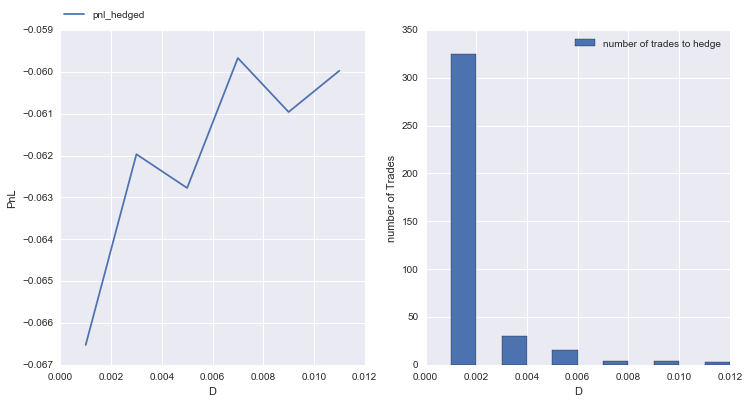

In [29]:
DList = np.arange(0.001,0.013,0.002)
strat,ParaList, x1,y1,x2,y2 = hedging1, DList, 'D','PnL','D','number of Trades'
args = (Tdata, Odata,cdata, expirationday, tradeday, Strike, otype)
res = drawStat(strat,ParaList,x1,y1,x2,y2,*args)

In [30]:
res['pnlList'].max()

-0.059669305392739604

1. As D goes up, number of trades will go down. 
2. As D goes up, PnL seems gradually go up.

### 2.  Hedge every M minutes (M is between 30-240)

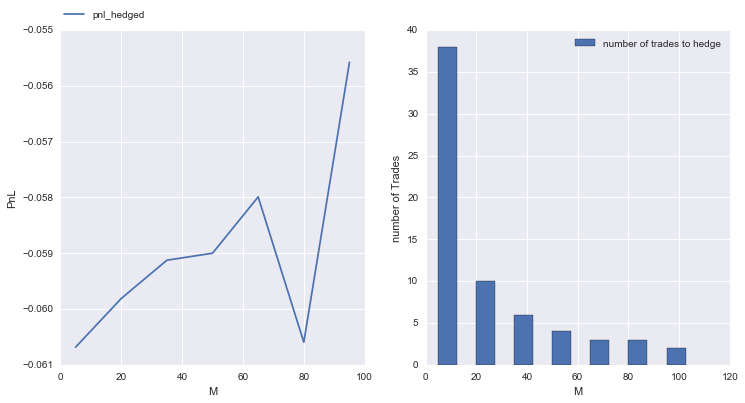

In [31]:
MList = range(5,100,15)
args = (Tdata, Odata,cdata, expirationday, tradeday, Strike, otype)
strat,ParaList, x1,y1,x2,y2 = hedging2, MList, 'M','PnL','M','number of Trades'
res = drawStat(strat,ParaList,x1,y1,x2,y2,*args)

In [32]:
res['pnlList'].max()

-0.055578173067252122

1. As M goes up, number of trades will go down. 
2. As M goes up, PnL seems gradually go up.

### 3. Hedge every T trades of futures

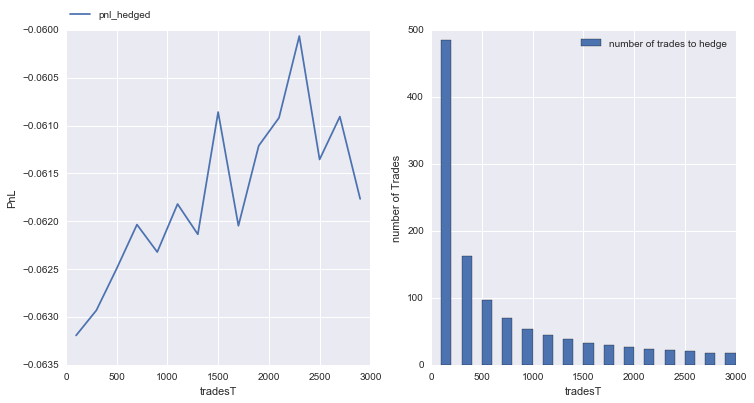

In [33]:
tradesTList = range(100,3000,200)
args = (Tdata, Odata,cdata, expirationday, tradeday, Strike, otype)
strat,ParaList, x1,y1,x2,y2 = hedging3, tradesTList, 'tradesT','PnL','tradesT','number of Trades'
res = drawStat(strat,ParaList,x1,y1,x2,y2,*args)

In [34]:
res['pnlList'].max()

-0.060063487485405173

1. As tradeT goes up, number of trades will go down. 
2. As tradeT goes up, PnL seems swinging.

Fuctions to get statistics and draw plot for strat 4

In [48]:
def getStat4(strat,DList,MList,tradesTList,*args):
    pnlList,pnl_nohedge_List, num_trades =[],[],[]
    res = []
    for D in DList:
        for M in MList:
            for tradesT in tradesTList:
                pnl_final, _, fuPosList, pnl_no_hedging = strat(D, M, tradesT, *args)
                res.append([D,M,tradesT,pnl_final,pnl_no_hedging,len(fuPosList)])
    res = pd.DataFrame(res)
    res.columns =['D','M','tradesT','pnl_final','pnl_no_hedging','NumOfTrades']
    return res #pnlList,pnl_nohedge_List, num_trades

### 4. Combine 1,2,3

In [49]:
strat = hedging4
DList = [0.003,0.007, 0.011]
MList = [10, 20, 30]
tradesTList = [500,1500, 2500]
args = (Tdata, Odata,cdata, expirationday, tradeday, Strike, otype)
res4 = getStat4(strat,DList,MList,tradesTList,*args)

Belos is the result contain the PnL and Number of Trades under different D, M, tradeT; we could do some small summary.

In [50]:
res4[:5]

,D,M,tradesT,pnl_final,pnl_no_hedging,NumOfTrades
0,0.003,10,500,-0.064167,-0.1,123
1,0.003,10,1500,-0.063999,-0.1,73
2,0.003,10,2500,-0.063790,-0.1,62
3,0.003,20,500,-0.064167,-0.1,123
4,0.003,20,1500,-0.063910,-0.1,70


In [51]:
res4['pnl_final'].max()

-0.06085782412672245

We could see from the maximum value of hedge4 statistics, the best PnL of hedge 4 is worse than PnL of hedge1,2,3 with the same parameters. Therefore, combining too many constraints may not be the best way to work on hedging.

In [52]:
res4['pnl_final'].groupby(res4['D']).mean()

D
0.003   -0.063954
0.007   -0.061922
0.011   -0.061703
Name: pnl_final, dtype: float64

In [53]:
res4['pnl_final'].groupby(res4['M']).mean()

M
10   -0.062632
20   -0.062508
30   -0.062438
Name: pnl_final, dtype: float64

In [54]:
res4['pnl_final'].groupby(res4['tradesT']).mean()

tradesT
500    -0.063082
1500   -0.062111
2500   -0.062385
Name: pnl_final, dtype: float64

We could see that D = 0.007, M = 20 and tradeT = 1500  are optimal ones

## B. ANALYSIS ON THE DAY WHEN OPTIONS PRICE GO UP

We will take 2014-10-13 as an example.

In [36]:
expirationday ='2014-12-16'
tradeday = '2014-10-13'
Odata = dense_opt_prices.ix[datetime.datetime(2014,int(tradeday[5:7]),int(tradeday[8:10]),8):
                            datetime.datetime(2014,int(tradeday[5:7]),int(tradeday[8:10]),15)]
ostart, oend, starttime, endtime = Odata.iloc[0]['Oprice'], Odata.iloc[-1]['Oprice'], Odata.index[0], Odata.index[-1]
Tdata = dense_trade_prices.ix[starttime: endtime]
Tdata = pd.DataFrame(Tdata)
Tdata.columns=['Fprice']
otype ='P'
Strike = 1865
#ostart, oend, starttime, endtime

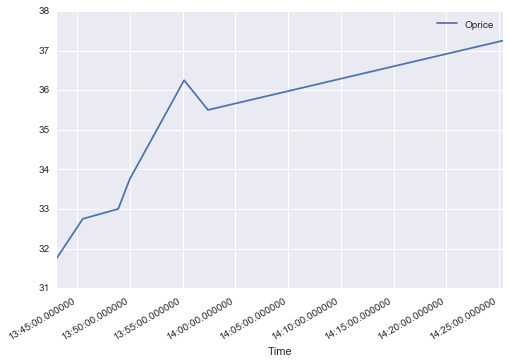

In [37]:
Odata.plot()

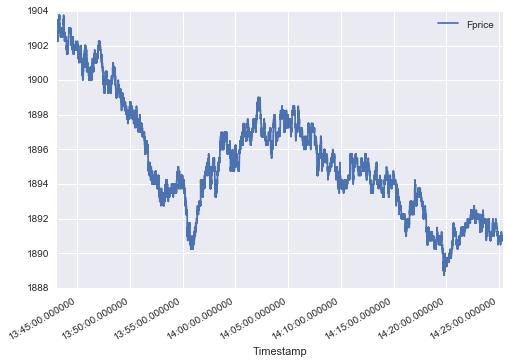

In [38]:
Tdata.plot()

### 1. Strat1

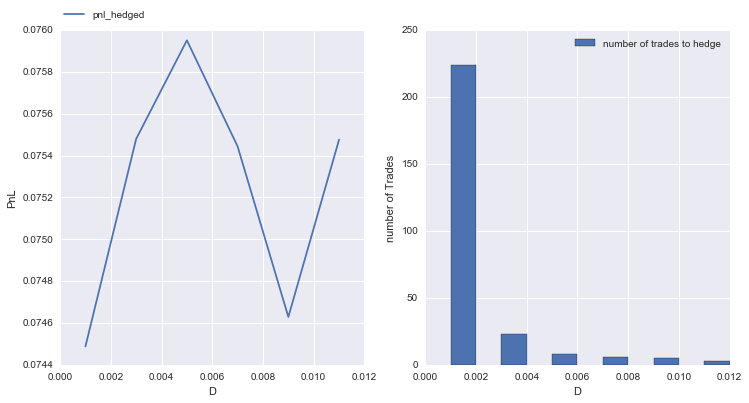

In [39]:
DList = np.arange(0.001,0.013,0.002)
strat,ParaList, x1,y1,x2,y2 = hedging1, DList, 'D','PnL','D','number of Trades'
args = (Tdata, Odata,cdata, expirationday, tradeday, Strike, otype)
res = drawStat(strat,ParaList,x1,y1,x2,y2,*args)

In [40]:
res['pnlList'].max()

0.075950788559577459

1. As D goes up, number of trades will go down.
2. As D goes up, PnL seems swinging.

## 2. Strat2

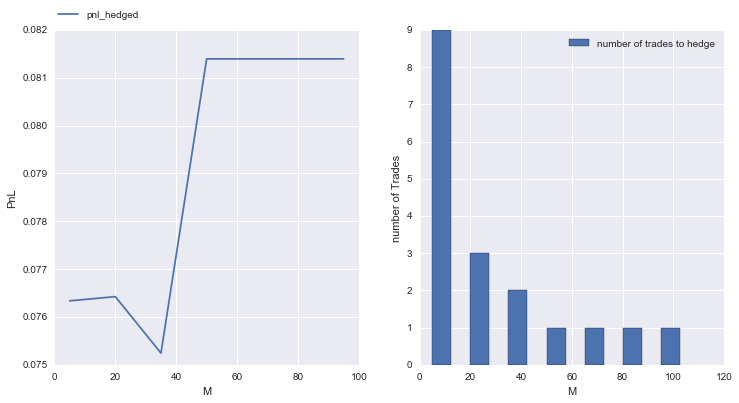

In [41]:
MList = range(5,100,15)
args = (Tdata, Odata,cdata, expirationday, tradeday, Strike, otype)
strat,ParaList, x1,y1,x2,y2 = hedging2, MList, 'M','PnL','M','number of Trades'
res = drawStat(strat,ParaList,x1,y1,x2,y2,*args)

In [42]:
res['pnlList'].max()

0.081395892608689457

1. As M goes up, number of trades will go down.
2. As M goes up, PnL seems going up, but we could see there is no trade there.

## 3. Strat3

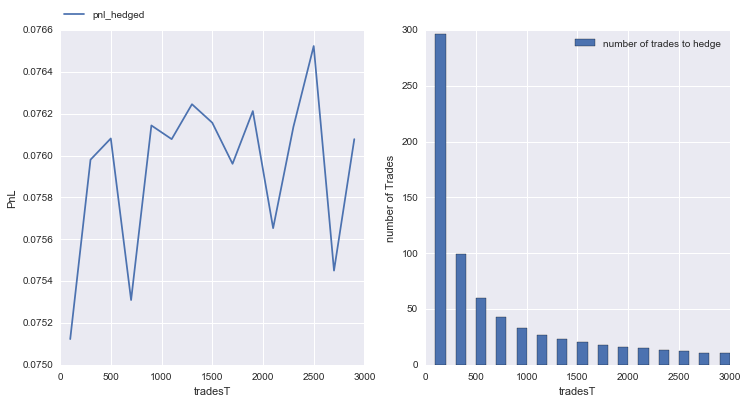

In [43]:
tradesTList = range(100,3000,200)
args = (Tdata, Odata,cdata, expirationday, tradeday, Strike, otype)
strat,ParaList, x1,y1,x2,y2 = hedging3, tradesTList, 'tradesT','PnL','tradesT','number of Trades'
res = drawStat(strat,ParaList,x1,y1,x2,y2,*args)

In [44]:
res['pnlList'].max()

0.076523440728204675

1. As tradeT goes up, number of trades will go down.
2. As tradeT goes up, PnL seems swinging.

## 4. Strat4

In [305]:
strat = hedging4
DList = [0.003,0.007, 0.011]
MList = [10, 20, 30]
tradesTList = [500,1500, 2500]
args = (Tdata, Odata,cdata, expirationday, tradeday, Strike, otype)
res4 = getStat4(strat,DList,MList,tradesTList,*args)

In [306]:
res4[:5]

,D,M,tradesT,pnl_final,pnl_no_hedging,NumOfTrades
0,0.003,10,500,0.076003,0.173228,67
1,0.003,10,1500,0.076209,0.173228,33
2,0.003,10,2500,0.075476,0.173228,33
3,0.003,20,500,0.076003,0.173228,67
4,0.003,20,1500,0.076209,0.173228,33


In [307]:
res4['pnl_final'].max()

0.076523440728204675

In [308]:
res4['pnl_final'].groupby(res4['D']).mean()

D
0.003    0.075896
0.007    0.075957
0.011    0.076254
Name: pnl_final, dtype: float64

In [309]:
res4['pnl_final'].groupby(res4['M']).mean()

M
10    0.076036
20    0.076036
30    0.076036
Name: pnl_final, dtype: float64

In [311]:
res4['pnl_final'].groupby(res4['tradesT']).mean()

tradesT
500     0.076056
1500    0.076174
2500    0.075878
Name: pnl_final, dtype: float64

We could see that D = 0.007 and tradeT = 1500  are optimal ones.
And there is no difference as M is bigger than 10, which means all the other trading criteria have make trades more frequent than 1 trade per 10 min.

## Analysis of down market and up market.

1. Both in down market and up market, strategy 4 is not better than strategy 1,2,3. 
2. Strategy 2 always has the best maximum pnl in both markets among 4 strategies.
2. For Stragety 4, it is optimal to choose D = 0.007, and tradeT = 1500 in both down and up markets.
